# GAN for celebrity face generation

This is my implementation of [PyTorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on celebrity face generation using GANS

## Dataset

For training the model the we will use the same dataset used in the original tutorial. It can be downloaded from this [link](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). If the previous link does not work, you can download the data from [archive.org](https://archive.org/details/celeba)

## Loading the Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fileroot = '../data'
device = "cuda"
image_size = 64
batch_size = 128
lr = 0.0002

In [3]:
transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = dset.ImageFolder(fileroot, transform=transforms)

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

we can now visualize some training examples

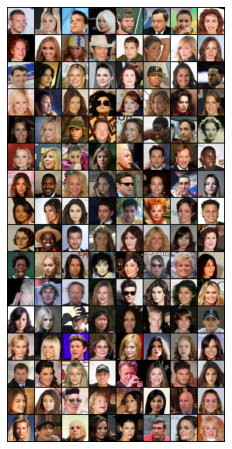

In [5]:
sample_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    sample_batch[0].to(device), padding=2, normalize=True).cpu(),
    (1,2,0)))

## Building The Model

According to the DCGAN paper, all model weights need to be randomly initialized from a Normal distribution with mean=0 and std.=0.02

In [6]:
# custom weight initializer
def init_weights(layer):
    name = layer.__class__.__name__
    if name.find('Conv') != -1:
        nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif name.find('BatchNorm') != -1:
        nn.init.normal_(layer.weight.data, 1.0, 0.02)
        nn.init.constant_(layer.bias.data, 0)

## Parameters

In [7]:
#Number of channels 
no_channels = 3

# Size of z latent vector 
latent_vector_size = 100

# Size of feature maps in generator
feature_map_gen_size = 64

# Size of feature maps in discriminator
feature_map_disc_size = 64

## Generator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
        nn.ConvTranspose2d(latent_vector_size, feature_map_gen_size * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(feature_map_gen_size * 8),
        nn.ReLU(True),
        nn.ConvTranspose2d(feature_map_gen_size * 8, feature_map_gen_size * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_gen_size * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(feature_map_gen_size * 4, feature_map_gen_size * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_gen_size * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(feature_map_gen_size * 2, feature_map_gen_size, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_gen_size),
        nn.ReLU(True),
        nn.ConvTranspose2d(feature_map_gen_size, no_channels, 4, 2, 1, bias=False),
        nn.Tanh())
    
    def forward(self, input):
        return self.main(input)

we can now create a generator and initialize the weights

In [9]:
net_generator = Generator().to(device)
net_generator.apply(init_weights)
net_generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
        nn.Conv2d(no_channels, feature_map_disc_size, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(feature_map_disc_size, feature_map_disc_size * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_disc_size * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(feature_map_disc_size * 2, feature_map_disc_size * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_disc_size * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(feature_map_disc_size * 4, feature_map_disc_size * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_disc_size * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(feature_map_disc_size * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid())
        
    def forward(self, input):
        return self.main(input)

we can now create a discriminator and initialize the weights

In [11]:
net_discriminator = Discriminator().to(device)
net_discriminator.apply(init_weights)
net_discriminator

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Loss Functions

we will use the Binary Cross Entropy loss.

Also, we will need two optimizers one for each network.

In [12]:
# loss
criterion = nn.BCELoss()

In [13]:
# optimizers
optimizer_discriminator = optim.Adam(net_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_generator = optim.Adam(net_generator.parameters(), lr=lr, betas=(0.5, 0.999))

## Training

Part 1 : **Train the Discriminator**
    
  * construct a batch of real samples from the training set
  *  forward pass through the discriminator
  * calculate the loss 
  * calculate the gradients in the backward pass
  * construct a batch of fake samples with the current generator
  * forward pass this batch through the discriminator
  * calculate the loss
  * accumulate the gradients with a backward pass
    
Part 2: **Train the Generator**

   * classify the generator output from part 1 with the discriminator
   * compute the loss using thereal labels
   * compute the gradients in the backward pass
    

In [14]:
img_list = []
gen_losses = []
disc_losses = []
iters = 0
num_epochs = 2
fixed_noise = torch.randn(64, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    
    for i, data in enumerate(dataloader, 0):
        
        # (1) Discriminator Network
        ################################
        
        net_discriminator.zero_grad()
        real = data[0].to(device)
        bs = real.size(0)
        label = torch.full((bs,), real_label, device=device)
        
        # train with real data
        # forward pass through discriminator
        output = net_discriminator(real).view(-1)
        err_disc_real = criterion(output, label)
        err_disc_real.backward()
        
        # average output
        disc_x = output.mean().item()
        
        # train with fake data
        noise = torch.rand(bs, latent_vector_size, 1,1,device=device)
        
        fake = net_generator(noise)
        label.fill_(fake_label)
        
        output = net_discriminator(fake.detach()).view(-1)
        err_disc_fake = criterion(output, label)
        err_disc_fake.backward()
        
        disc_gen_z1 = output.mean().item()
        
        # add the gradients from real and fake samples
        err_disc = err_disc_real + err_disc_fake
        optimizer_discriminator.step()
        
        # (2) Generator Network
        ################################
        net_generator.zero_grad()
        label.fill_(real_label)
        
        output = net_discriminator(fake).view(-1)
        err_gen = criterion(output, label)
        err_gen.backward()
        
        disc_gen_z2 = output.mean().item()
        
        optimizer_generator.step()
        
        
        # print stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err_disc.item(), err_gen.item(), disc_x, disc_gen_z1, disc_gen_z2))

            
        gen_losses.append(err_gen.item())
        disc_losses.append(err_disc.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_generator(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils .make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/2][0/1583]	Loss_D: 2.0387	Loss_G: 14.0337	D(x): 0.5264	D(G(z)): 0.6875 / 0.0000
[0/2][50/1583]	Loss_D: 0.8631	Loss_G: 8.8553	D(x): 0.6972	D(G(z)): 0.0045 / 0.0002
[0/2][100/1583]	Loss_D: 0.9954	Loss_G: 16.1358	D(x): 0.8907	D(G(z)): 0.5215 / 0.0000
[0/2][150/1583]	Loss_D: 0.3063	Loss_G: 8.8856	D(x): 0.9742	D(G(z)): 0.2182 / 0.0002
[0/2][200/1583]	Loss_D: 0.2143	Loss_G: 5.5893	D(x): 0.9410	D(G(z)): 0.0820 / 0.0048
[0/2][250/1583]	Loss_D: 0.2241	Loss_G: 4.0608	D(x): 0.9528	D(G(z)): 0.0928 / 0.0183
[0/2][300/1583]	Loss_D: 0.2892	Loss_G: 5.3867	D(x): 0.8774	D(G(z)): 0.0015 / 0.0046
[0/2][350/1583]	Loss_D: 0.3239	Loss_G: 4.9504	D(x): 0.8939	D(G(z)): 0.0671 / 0.0073
[0/2][400/1583]	Loss_D: 0.1566	Loss_G: 8.4484	D(x): 0.9650	D(G(z)): 0.1024 / 0.0003
[0/2][450/1583]	Loss_D: 0.1596	Loss_G: 3.9775	D(x): 0.9276	D(G(z)): 0.0463 / 0.0241
[0/2][500/1583]	Loss_D: 0.1596	Loss_G: 6.6190	D(x): 0.9583	D(G(z)): 0.0935 / 0.0014
[0/2][550/1583]	Loss_D: 0.1581	Loss_G: 5.5599	D(x):

## Results

we can plot Generator and Discriminator losses during training

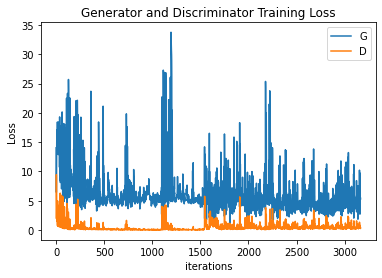

In [15]:
plt.title("Generator and Discriminator Training Loss")
plt.plot(gen_losses, label="G")
plt.plot(disc_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()